# Forecast IC-capacity for the next year
---

In [519]:
# Importeren van de benodigde libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns # Kan mogelijk weg.
from os import path, getcwd
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pmd
import statsmodels.api as sm

# Negeren van filterwarnings
warnings.filterwarnings("ignore")

## Inladen van de benodigde datasets
---

In [520]:
# Dataset path
root_dir = path.join(getcwd(), 'Datasets')
alle_cijfers = path.join(root_dir, "Kopie van AlleCijfers-Corona-besmet-opgenomen-overleden.xlsx")

# Inlezen benodigde CSV-bestanden
df_per_dag = pd.read_csv(path.join(root_dir, "data_per_dag.csv"))
df_per_leeftijd = pd.read_csv(path.join(root_dir, "data_per_leeftijd.csv"))
df_per_dag_recent = pd.read_excel(alle_cijfers, sheet_name="NICE")

# Eerste week van df_per_dag halen, zodat de tijdranges in beide datasets overeen komen.
df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
df_per_dag = df_per_dag.loc[(df_per_dag["Date_adj"] >= "2020-04-01") & (df_per_dag["Date_adj"] < "2021-11-01")]

df_per_dag_recent.head(5)

,Datum,Aanwezig op IC verdacht of bewezen Corona,Aanwezig op verpleegafdeling verdacht of bewezen Corona,Opname IC Corona,Opname IC verdacht,Opname IC totaal,Opname verpleegafdeling Corona,Opname verpleegafdeling verdacht,Opname verpleegafdeling totaal,Overleden,Levend het ziekenhuis verlaten,Levend de IC verlaten,Cumulatief op IC (geweest) verdacht of bewezen Corona,Cumulatief op verpleegafdeling (geweest) verdacht of bewezen Corona
0,2022-01-16,333,959,4,0,4,10,1,11,4628,11363,278,16914,78040
1,2022-01-15,340,997,10,0,10,33,11,44,4628,11363,278,16910,78032
2,2022-01-14,359,1039,9,0,9,63,13,76,4625,11357,275,16900,77996
3,2022-01-13,377,1096,14,0,14,72,9,81,4618,11341,270,16891,77930
4,2022-01-12,392,1144,11,0,11,85,6,91,4607,11318,276,16877,77863


In [521]:
# Set index dataset

df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
Index_df_per_dag = df_per_dag[["Aanwezig op IC verdacht of bewezen Corona", "Date_adj"]]
Index_df_per_dag.set_index(["Date_adj"], inplace=True)

Index_df_per_dag

,Aanwezig op IC verdacht of bewezen Corona
Date_adj,
2021-10-31,231
2021-10-30,222
2021-10-29,234
2021-10-28,220
2021-10-27,216
...,...
2020-04-05,1312
2020-04-04,1285
2020-04-03,1279


In [522]:
# Replace daily numbers with montly averages
#Index_df_per_dag["IC-capaciteit_log"] = np.log(Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"])
Index_df_per_dag = Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"].resample("W").max()

Index_df_per_dag


Date_adj
2020-04-05    1312
2020-04-12    1321
2020-04-19    1228
2020-04-26    1020
2020-05-03     787
              ... 
2021-10-03     164
2021-10-10     143
2021-10-17     150
2021-10-24     196
2021-10-31     234
Freq: W-SUN, Name: Aanwezig op IC verdacht of bewezen Corona, Length: 83, dtype: int64

## Verdelen van de dataset in een train- en testset.
---

In [523]:
train = Index_df_per_dag[:63]
test = Index_df_per_dag[63:]
len(Index_df_per_dag)

83

# Building the ARIMA-model
---
1. p-value bepalen met behulp van de Augmented Dickey Fuller test.
2. Predict p, q and d
3. Build model
4. Visualize model
5. Evaluate model

p-value: 0.000097


<AxesSubplot:xlabel='Date_adj'>

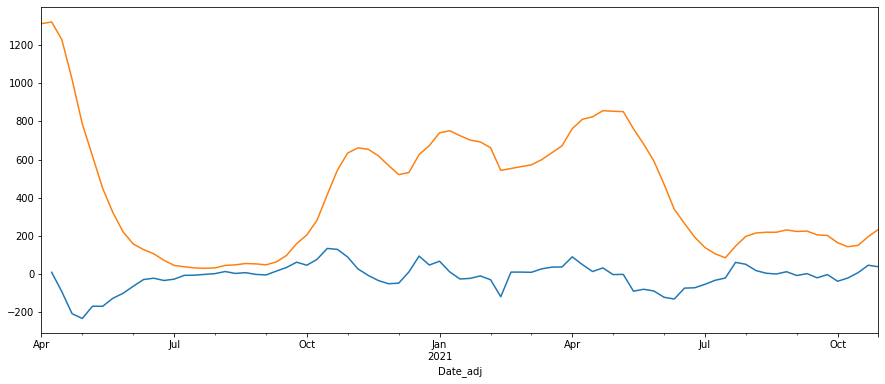

In [524]:
# Get P-value
diff_1 = Index_df_per_dag.diff(1).dropna()
result = adfuller(Index_df_per_dag)
print("p-value: %f" % result[1])

diff_1.plot(figsize=(15,6))
Index_df_per_dag.plot()

Uit de resultaten van bovenstaande cel blijkt de p-value, die de stationary van de data weergeeft, pas na een diff toe te passen op een waarde onder de 0,05 uit te komen. Hieruit kan geconcludeerd worden dat de d binnen het Arima-model de waarde **0** zou moeten krijgen.

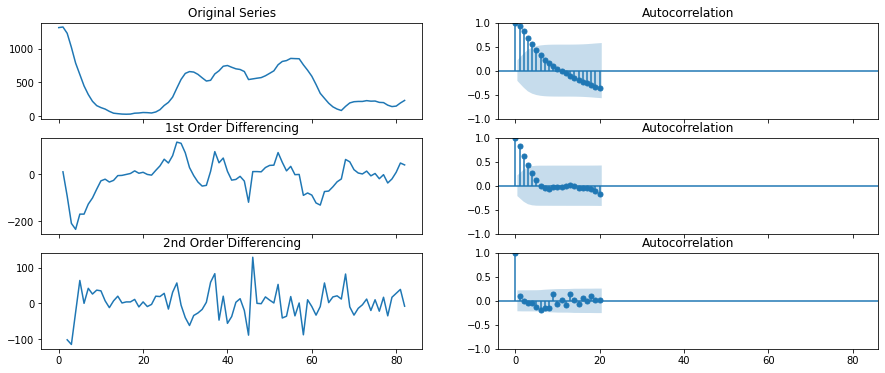

In [525]:
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(15,6))
axes[0, 0].plot(Index_df_per_dag.values); axes[0, 0].set_title('Original Series')
plot_acf(Index_df_per_dag, ax=axes[0, 1])


# 1st Differencing
axes[1, 0].plot(Index_df_per_dag.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(Index_df_per_dag.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Index_df_per_dag.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(Index_df_per_dag.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

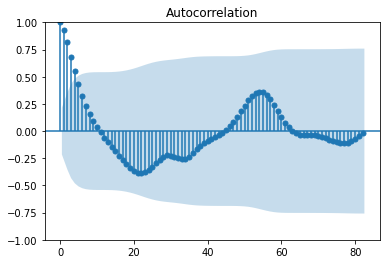

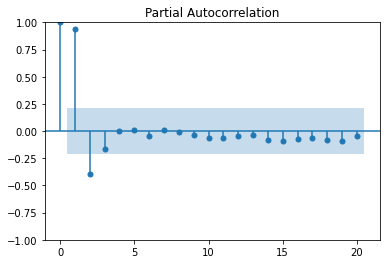

In [526]:
# Find the q, MA-term
plot_acf(Index_df_per_dag, lags=len(Index_df_per_dag)-1)

# Find the p, AR-term --> 1 
plot_pacf(Index_df_per_dag)

plt.show()

### Gevonden parameters
----
Naar aanleiding van de bovenstaande grafieken zou de order van ARIMA er als volgt uit moeten zien:
* p &#8594; 4
* d &#8594; 0
* q &#8594; 1 of 2

De q-variabele is hier de grote onzekere. Twee parameters binnen de Partial Autocorrelation vallen buiten het gebied, echter is een parameter positief en de andere negatief. Naar aanleiding van de resultaten binnen de Partial Autocorrelation zou q 1 moeten zijn, aangezien de tweede parameter negatief is. Later binnen dit notebook worden ARIMA-modellen getraind met beide q-waardes. 
    
Het packet pmdarima maakt het mogelijk de ARIMA-parameters (p,d,q) te bepalen aan de hand van een aantal parameters. In de voglende cel worden aan de hand van de module "auto_arima" de meest passende parameters bepaald. Deze worden net zoals de met de hand uitgerekende parameters later binnen dit notebook getraind. Het ARIMA-model met de laagste Root Mean Squared Error wordt gebruikt voor het voorspellen van de benodigde IC-capaciteit.

In [527]:
# def arimamodel(timeseriesarray):

#     autoarima_model = pmd.auto_arima(timeseriesarray, 
#                               start_p=0, 
#                               start_q=0,
#                               test="adf",
#                               d=None,
#                               m=52,
#                               approximation=True,
#                               Seasonal=True,
#                               trace=True)

#     return autoarima_model

# arimamodel(Index_df_per_dag)

Uit de auto_arima-functie komen de volgende parameters:
* p &#8594; 2
* d &#8594; 1
* q &#8594; 1

Naast de standaard ARIMA-order is een optimale seasonal_order gegeven. De optimale seasonal order ziet er als volgt uit:
* P &#8594; 1
* D &#8594; 0
* Q &#8594; 0
* Periode &#8594; 52

De periode heeft de waarde 52 gekregen. Dit getal geeft het aantal stappen weer die nodig zijn om een seasonal period, in dit geval een jaar, te doorlopen. 

In de volgende cel wordt het ARIMA-model getraind.

In [528]:
orders = np.array([[2,1,1], [4,0,1], [4,0,2]])
rmse = []

for i in orders:
    model = ARIMA(Index_df_per_dag, order=(i)).fit()
    pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))
    rmse_value = np.mean((pred - test.values)**2)**.5
    rmse.append(rmse_value)
    rmse_value

min_rmse = min(rmse)
index_rmse = rmse.index(min_rmse)
best_order = orders[index_rmse]

print("De ARIMA-order met de laagste Root Mean Squared Error is: ",best_order , "met een waarde van: ", min_rmse,"."\
    " Vanaf dit punt wordt bij het trainen van de verschillende modellen de volgende order aangehouden: 4,0,2.")

De ARIMA-order met de laagste Root Mean Squared Error is:  [4 0 2] met een waarde van:  22.794769782923968 . Vanaf dit punt wordt bij het trainen van de verschillende modellen de volgende order aangehouden: 4,0,2.


Text(0, 0.5, 'Benodigde IC-capaciteit per maand.')

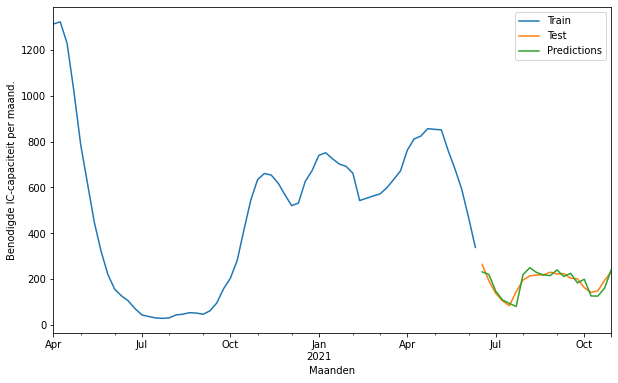

In [529]:
# Build model with the best parameters
model = ARIMA(Index_df_per_dag, order=(2,1,1)).fit()
pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))

#Plot results 
train.plot(legend=True, label="Train", figsize=(10,6))
test.plot(legend=True, label="Test")
pred.plot(legend=True, label="Predictions")
plt.xlabel("Maanden")
plt.ylabel("Benodigde IC-capaciteit per maand.")

In [530]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:     Aanwezig op IC verdacht of bewezen Corona   No. Observations:                   83
Model:                                        ARIMA(2, 1, 1)   Log Likelihood                -410.807
Date:                                       Mon, 17 Jan 2022   AIC                            829.613
Time:                                               16:16:27   BIC                            839.240
Sample:                                           04-05-2020   HQIC                           833.478
                                                - 10-31-2021                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6535      0.161     10.275      0.000       1.338       1.969
ar.L2         -0.7567      0.135     -5.625      0.000      -1.020      -0.493
ma.L1         -0.6631      0.205     -3.229      0.001      -1.066      -0.261
sigma2      1292.4415    160.267      8.064      0.000     978.324    1606.559
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                15.68
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.20
Prob(H) (two-sided):                  0.53   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Uit de grafiek blijkt dat de predictiewaarden nagenoeg overeen komen met de testwaardes. Hieruit lijkt vooralsnog het model adequaat te zijn. In de volgende cel wordt een predictie met behulp van ARIMA gemaakt die de IC-capaciteit per week tot en met 1 november 2022 voorspeld.

# Validate model with 2020 data
---
< Dit onderdeel moet nog verplaatst worden >

In [531]:
# Create Train and Test set
train_2020 = Index_df_per_dag[:39]
test_2021 = Index_df_per_dag[39:]

In [532]:
model_2020 = ARIMA(Index_df_per_dag, order=(2,1,1)).fit()

pred_2020 = model_2020.predict(start=len(train_2020), end=(len(Index_df_per_dag) -1))

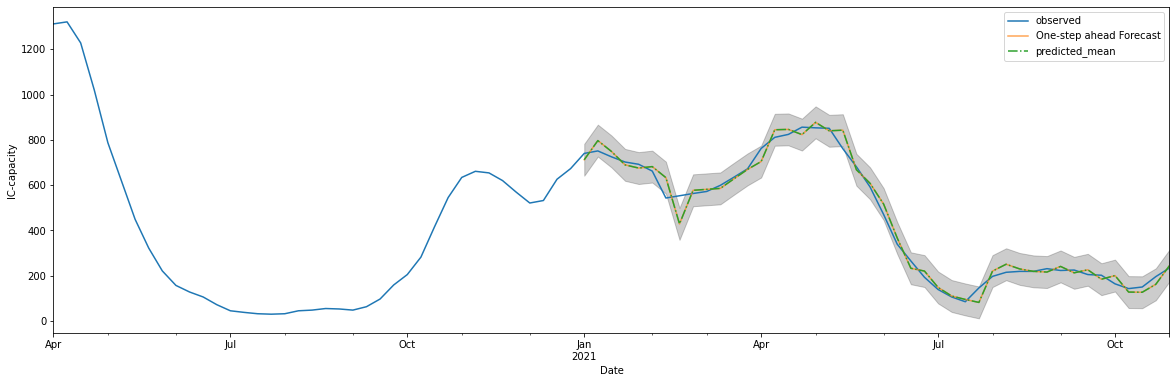

In [533]:
# Visualize predictions v.s. test values
pred = model_2020.get_prediction(start=pd.to_datetime('2021-01-03'), dynamic=False)
pred_ci = pred.conf_int()

# Plotting IC-capacity
ax = Index_df_per_dag['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20,6))
pred_2020.plot(ls="-.")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
plt.legend()

plt.show()

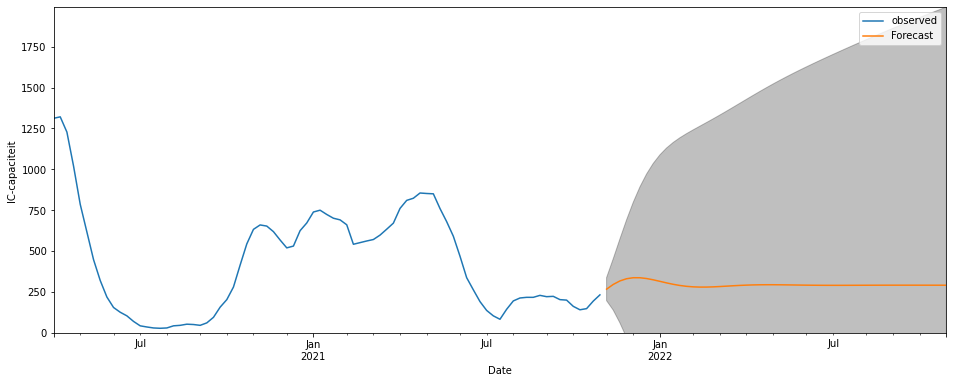

In [534]:
# Predict the future data.
final_model = ARIMA(Index_df_per_dag, order=(2,1,1)).fit()

prediction = final_model.predict(len(Index_df_per_dag), len(Index_df_per_dag) + 365)

# Dezelfde plot als bovenstaande cel, met onzekerheid.
# Get forecast 12 steps ahead in future
pred_uc = final_model.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the model
ax = Index_df_per_dag.plot(label='observed', figsize=(16,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IC-capaciteit')
ax.set_ylim(0,pred_ci.iloc[:, 1].max())

plt.legend()
plt.show()

De predicties die vanuit het ARIMA-model naar voren zijn gekomen zijn te vinden in bovenstaande grafiek. Binnen de grafiek is te zien dat de oranje lijn (de voorspellingen, na februari 2022 afvlakken. Daarnaast is te zien dat het onzekere gebied, het grijze vlak, steeds onzekerder wordt. Naar aanleiding [van het forum stats.stackexchange](https://stats.stackexchange.com/questions/286900/arima-forecast-straight-line) lijkt de stagnering te komen doordat ARIMA geen rekening kan houden en daardoor seizoenen niet herkend. Een model dat hier wel rekening mee houdt is SARIMA. In de onderstaande cel worden drie ARIMA-modellen opgebouwd met de eerder genoemde orders, namelijk:
1. 2,1,1
2. 4,0,1
3. 4,0,2

In [535]:
model1 = sm.tsa.statespace.SARIMAX(Index_df_per_dag,
                                order=(2,1,1),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

model2 = sm.tsa.statespace.SARIMAX(Index_df_per_dag,
                                order=(4,0,1),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)    

model3 = sm.tsa.statespace.SARIMAX(Index_df_per_dag,
                                order=(4,0,2),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)                        

results = model1.fit()

Nu de modellen zijn getraind worden de voorspellingen van de gerealiseerde modellen vergeleken met de IC-capaciteit van de periode 1 november 2021 tot en met 16 januari 2022. 

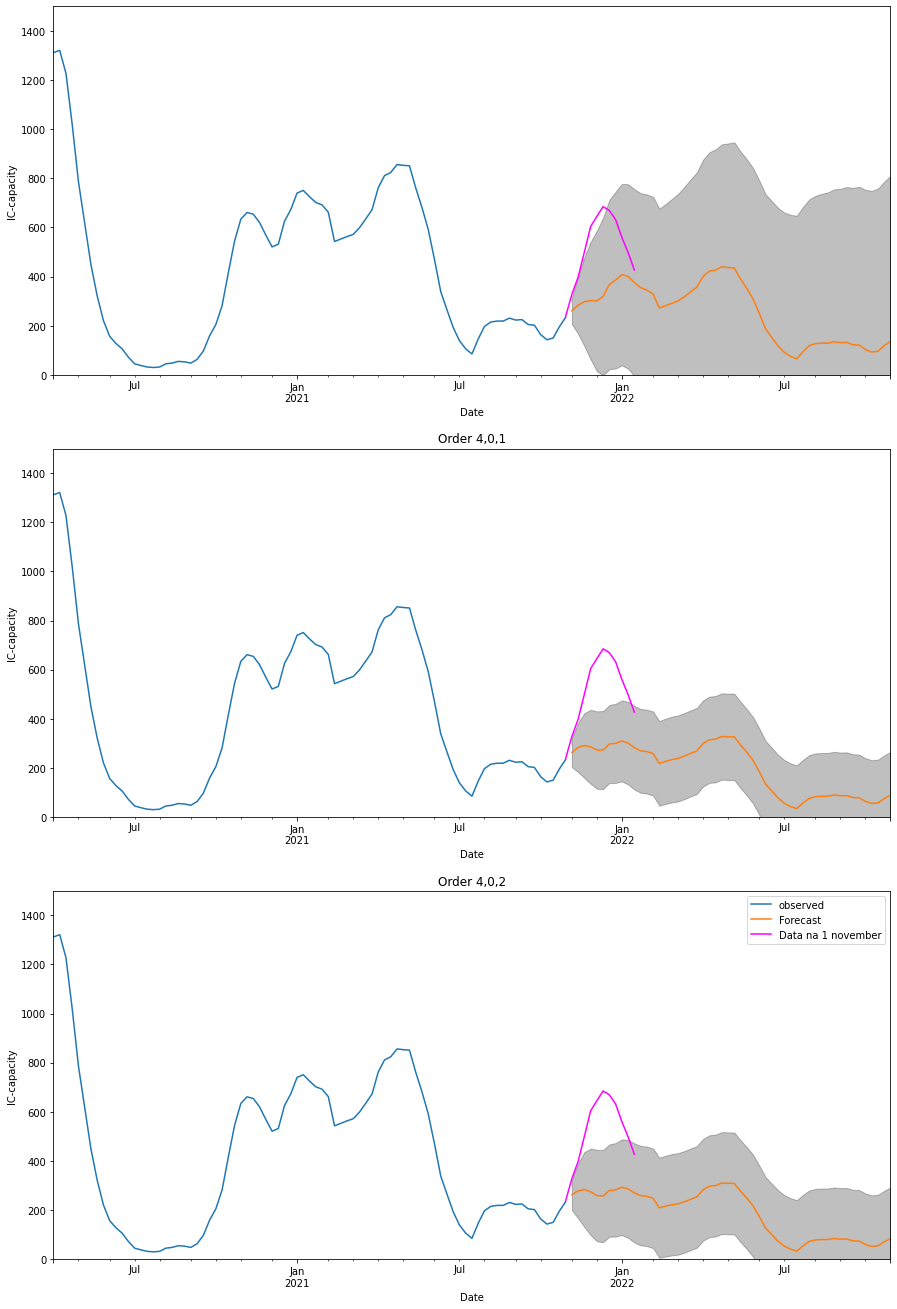

In [536]:
# Data preprocessing
df_per_dag_recent["Datum"] = pd.to_datetime(df_per_dag_recent["Datum"])
df_per_dag_recent = df_per_dag_recent.loc[(df_per_dag_recent["Datum"] >= "2020-04-01") & (df_per_dag_recent["Datum"] < "2022-01-16")]
Index_df_per_dag_recent = df_per_dag_recent[["Aanwezig op IC verdacht of bewezen Corona", "Datum"]]
Index_df_per_dag_recent.set_index(["Datum"], inplace=True)
Index_df_per_dag_recent = Index_df_per_dag_recent["Aanwezig op IC verdacht of bewezen Corona"].resample("W").max()

recent_data = Index_df_per_dag_recent[82:]

# Plot the results
plt.subplot(3,1,1)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=3, wspace=0.2, hspace=0.2)

#2,1,1
# Get forecast 52 steps ahead in future
pred_uc = results.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
recent_data.plot(label="Data na 1 november", color="magenta")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

# 4,0,1
results = model2.fit()
# Get forecast 52 steps ahead in future
pred_uc = results.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the results
plt.subplot(3,1,2)
ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
recent_data.plot(label="Data na 1 november", color="magenta")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("Order 4,0,1")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

# 4,0,2
results3 = model3.fit()
# Get forecast 52 steps ahead in future
pred_uc = results3.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the results
plt.subplot(3,1,3)
ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
recent_data.plot(label="Data na 1 november", color="magenta")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("Order 4,0,2")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

plt.legend()
plt.show()


Uit de grafieken blijkt het SARIMA-model met de order 2,1,1 het meest overeen te komen met de werkelijkheid. Daarom wordt het SARIMA-model met de order 2,1,1 nog een keer weergegeven binnen de volgende cel. 

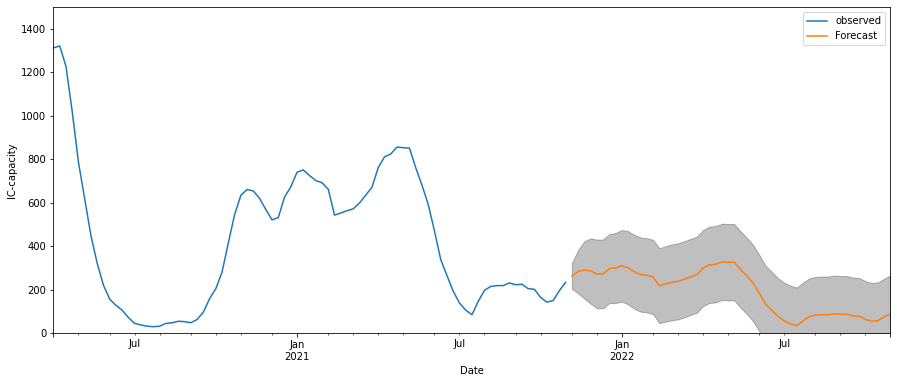

In [537]:
# Get forecast 52 steps ahead in future
pred_uc = results.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

plt.legend()
plt.show()

De IC-capaciteit die het SARIMA-model heeft voorspeld zijn te zien in bovenstaande grafiek (en eerdere gerealiseerde grafieken.). Naar aanleiding van de resultaten van het SARIMA-model blijkt de hypothese van [stats.stackexchange](https://stats.stackexchange.com/questions/286900/arima-forecast-straight-line) klopt. De voorspellingen hebben namelijk meer variatie zien. Daarnaast is de onzekerheid (het grijze gebied) aanzienlijk kleiner is dan het geval is bij het ARIMA-model. 

Uit de grafieken blijkt de order 2,1,1 de IC-capaciteit het beste te kunnen voorspellen. Hieruit kan geconcludeerd worden dat de order van zowel het ARIMA als SARIMA model 2,1,1 dient te zijn en door de auto_arima functionaliteit juist zijn voorspeld.

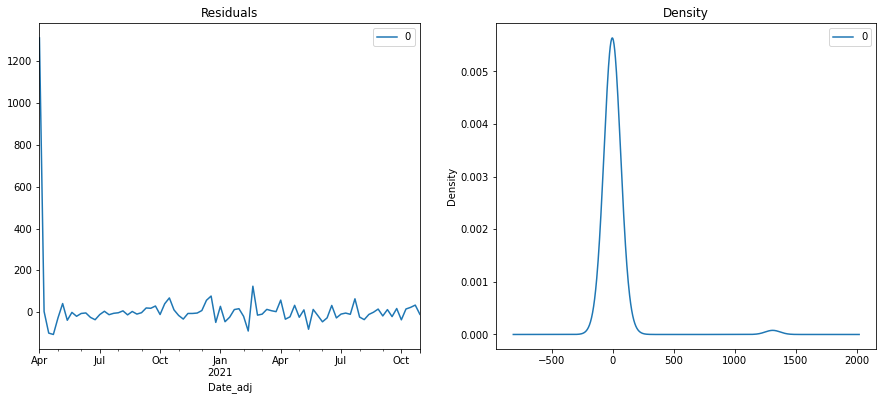

In [538]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2, figsize=(15,6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Binnen de Density grafiek is een kleine bult te zijn tussen de 1000 en 1500, dit kan een mogelijk outlier zijn. In de volgende cel wordt een boxplot weergegeven van de waardes die zich binnen het dataframe Index_df_per_dag bevinden. Dankzij deze boxplot worden eventuele outliers in kaart gebracht.

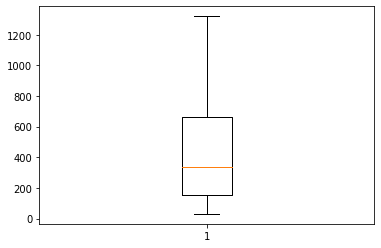

In [541]:
# Boxplot weergeven.
plt.boxplot(Index_df_per_dag)
plt.show()

Binnen het boxplot zijn geen outliers te zien. Hieruit kan geconcludeerd worden dat indien sprake is van een of meerdere outliers deze zo klein zijn dat ze waarschijnlijk het model niet beïnvloeden. 

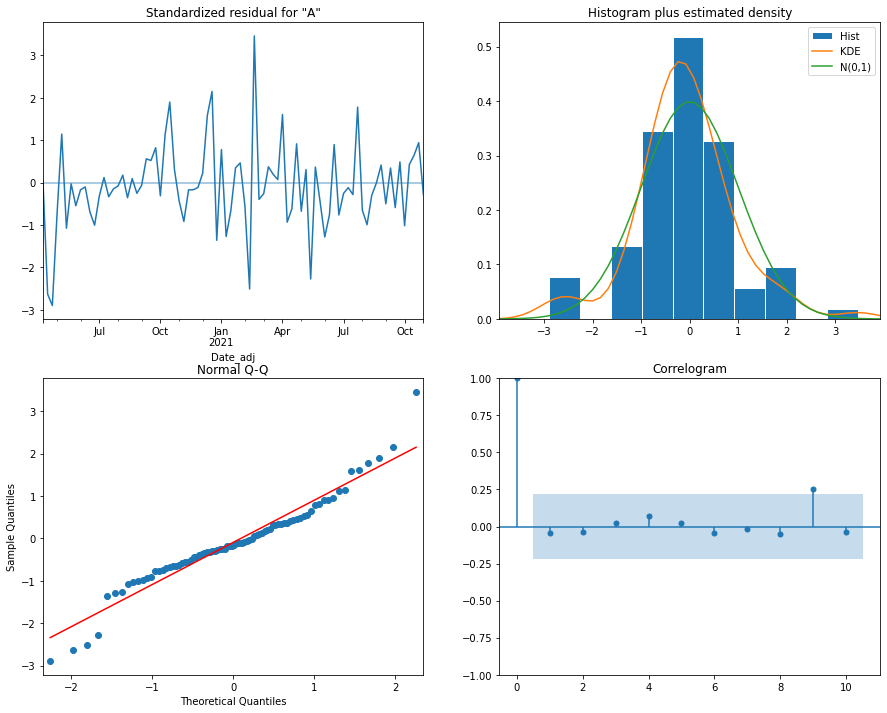

In [540]:
# Forecast testdata
final_model.plot_diagnostics(figsize=(15, 12))
plt.show()